In [1]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import xarray as xr
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pyproj
from scipy.interpolate import griddata
import cftime
from sklearn.linear_model import LinearRegression

In [ ]:
home_path = os.path.expanduser("~")

path = '/DataFiles'
era = xr.open_dataset(home_path + path + "/ae3baa6a74f0aa315dc3de6f83298f0e.nc")

path2 = '/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - MacBook Air/Python/Ice Cores/data/model/ccsm4_last_millenium'


In [3]:
# Loading the ice core accumulation records
accumData = pd.read_csv(home_path + path + "/AccumCoresData_NoBruce.csv", header=None)
print(accumData)

              0                      1          2             3            4   \
0    Site number                      1          2             3            4   
1           Year  vrs-13 (vostok stack)  B31 3.43W  B32 0.00667E  B33 6.4983E   
2           2020                    NaN        NaN           NaN          NaN   
3           2019                    NaN        NaN           NaN          NaN   
4           2018                    NaN        NaN           NaN          NaN   
..           ...                    ...        ...           ...          ...   
218         1804                  39.93       69.6          69.5         31.7   
219         1803                  17.04       75.7            78         41.1   
220         1802                  26.64       66.2          63.3         45.1   
221         1801                   5.79         52          62.9         44.6   
222         1800                  30.37         79          80.8         45.7   

            5          6   

In [4]:
# Loading the ERA5 metrics
era5Metrics = np.array(pd.read_csv(home_path + path + '/ERA5Metrics.csv'))

era5_accum_ais = era5Metrics[:, 1]
era5_accum_wais = era5Metrics[:, 2]
era5_accum_eais = era5Metrics[:, 3]
era5_temp_ais = era5Metrics[:, 4]
era5_temp_wais = era5Metrics[:, 5]
era5_temp_eais = era5Metrics[:, 6]
era5_accum_ap = era5Metrics[:, 7]

In [5]:
# Extracting the ice core accumulation data for the years 1979-2000
accumCores = accumData.iloc[2:, 1:][
    (accumData.iloc[2:, 0].astype(int) >= 1979) & (accumData.iloc[2:, 0].astype(int) <= 2000)
].to_numpy()[::-1]
accumCores = accumCores.astype(float)

print(accumCores.shape)

(22, 78)


In [6]:
# Finding correlations between the ERA5 metrics and each ice core accumulation record
n_cores = accumCores.shape[1]

correlations_accum_ais = np.zeros(n_cores)
correlations_accum_wais = np.zeros(n_cores)
correlations_accum_eais = np.zeros(n_cores)
correlations_accum_ap = np.zeros(n_cores)

for i in range(n_cores):
    y = accumCores[:, i]   # proxy series (22,)
    X_ais = era5_accum_ais         # ERA5 metric (22,)
    X_wais = era5_accum_wais         # ERA5 metric (22,)
    X_eais = era5_accum_eais         # ERA5 metric (22,)
    X_ap = era5_accum_ap         # ERA5 metric (22,)
    
    # Mask NaNs in either series
    valid_mask = ~np.isnan(y) & ~np.isnan(X_ais)
    y_valid = y[valid_mask]
    X_valid_ais = X_ais[valid_mask]
    X_valid_wais = X_wais[valid_mask]
    X_valid_eais = X_eais[valid_mask]
    X_valid_ap = X_ap[valid_mask]
    
    if len(y_valid) > 1:
        correlations_accum_ais[i] = np.corrcoef(y_valid, X_valid_ais)[0, 1]
        correlations_accum_wais[i] = np.corrcoef(y_valid, X_valid_wais)[0, 1]
        correlations_accum_eais[i] = np.corrcoef(y_valid, X_valid_eais)[0, 1]
        correlations_accum_ap[i] = np.corrcoef(y_valid, X_valid_eais)[0, 1]
    else:
        correlations_accum_ais[i] = np.nan
        correlations_accum_wais[i] = np.nan
        correlations_accum_eais[i] = np.nan
        correlations_accum_ap[i] = np.nan

In [7]:
# Importing ERA5 data, metadata about ice cores
era = xr.open_dataset(home_path + path + "/ae3baa6a74f0aa315dc3de6f83298f0e.nc")

# pr has units m -> convert to mm / kg m^2
pr = era["tp"] * 1000


lats = era["latitude"].values
lons = era["longitude"].values

# Compute number of days in each month (xarray provides days_in_month)
days_in_month = pr["valid_time"].dt.days_in_month
seconds_in_month = days_in_month 

# Convert monthly mean rate (mm/s) → monthly total (mm)
pr_monthly_total = pr * seconds_in_month

# Restrict to 1979–2000
pr_sel = pr_monthly_total.sel(valid_time=slice("1979-01-01", "2000-12-31"))

# Group by year and sum over months
pr_annual = pr_sel.groupby("valid_time.year").sum("valid_time")

# pr_annual is now ERA5 (year, lat, lon) with units mm/year
print(pr_annual.shape)

# Mapping the ice core locations to ERA5 indices
prCoords = pd.read_csv(home_path + path + "/AccumCoresCoords_NoBruce.csv", header=None)
coresLat = prCoords.iloc[:, 2].values
coresLonFirst = prCoords.iloc[:, 3].values
coresLon = (coresLonFirst + 360) % 360

# Select a numeric variable from your Dataset, e.g., 'tp' (replace with your variable name)
era_var = era["tp"]  # replace 'tp' with your actual variable name

lat_idx = []
lon_idx = []
grid_lats = []
grid_lons = []

for la, lo in zip(coresLat, coresLon):
    # Compute distances to all grid points
    lat_diff = np.abs(lats - la)[:, None]  # (n_lat, 1)
    lon_diff = np.abs(lons - lo)[None, :]  # (1, n_lon)
    dist = np.sqrt(lat_diff**2 + lon_diff**2)

    # Mask NaNs in the first valid_time slice
    mask = ~np.isnan(era_var.isel(valid_time=0).values)  # (n_lat, n_lon)
    dist_masked = np.where(mask, dist, np.inf)

    # Find indices of nearest valid grid cell
    i_lat, i_lon = np.unravel_index(np.argmin(dist_masked), dist_masked.shape)

    grid_lats.append(float(lats[i_lat]))
    grid_lons.append(float(lons[i_lon]))
    lat_idx.append(i_lat)
    lon_idx.append(i_lon)

# Store results back in DataFrame
prCoords["lat_idx"] = lat_idx
prCoords["lon_idx"] = lon_idx
prCoords["grid_lat"] = grid_lats
prCoords["grid_lon"] = grid_lons

print(prCoords.head())

accumCoordsInd = prCoords.iloc[:, 2:4].to_numpy()


(22, 301, 3600)
                       0                       1        2       3  lat_idx  \
0  vrs-13 (vostok stack)  Vostok composite VRS13 -78.4700  106.83      185   
1              B31 3.43W           B31Site DML07 -75.5800   -3.43      179   
2           B32 0.00667E           B32Site DML05 -75.0000   -0.01      179   
3            B33 6.4983E           B33Site DML17 -75.1700    6.50      152   
4              FB96DML01               FB96DML01 -74.8583   -2.55      179   

   lon_idx  grid_lat  grid_lon  
0     2868     -78.5     106.8  
1     3599     -77.9     179.9  
2     3599     -77.9     179.9  
3     1865     -75.2       6.5  
4     3599     -77.9     179.9  


In [30]:
data_mean = np.array(pr_annual) - np.array(pr_annual).mean(axis=0, keepdims=True)
ref_mean = era5_accum_eais - era5_accum_eais.mean()

# Compute numerator: covariance between ref and data
num = np.sum(data_mean * ref_mean[:, None, None], axis=0)

# Compute denominator: product of standard deviations
den = np.sqrt(np.sum(data_mean**2, axis=0) * np.sum(ref_mean**2))

# Pearson correlation
corr = num / den

/var/folders/4d/5th1wr_s21g614c74mcbh9kc0000gn/T/ipykernel_93143/2436012467.py:11: RuntimeWarning: invalid value encountered in divide
  corr = num / den


In [ ]:
# Creating an ERA5 data array spatially complete 1979-2000 annual precipitation
# pr has units m -> convert to mm / kg m^2
pr = era["tp"] * 1000


lats = era["latitude"].values
lons = era["longitude"].values

# Compute number of days in each month (xarray provides days_in_month)
days_in_month = pr["valid_time"].dt.days_in_month
seconds_in_month = days_in_month 

# Convert monthly mean rate (mm/s) → monthly total (mm)
pr_monthly_total = pr * seconds_in_month

# Restrict to 1979–2000
pr_sel = pr_monthly_total.sel(valid_time=slice("1979-01-01", "2000-12-31"))

# Group by year and sum over months
pr_annual = pr_sel.groupby("valid_time.year").sum("valid_time")

# pr_annual is now ERA5 (year, lat, lon) with units mm/year
print(pr_annual.shape)

(22, 301, 3600)


/opt/anaconda3/envs/cfr-env/lib/python3.13/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)


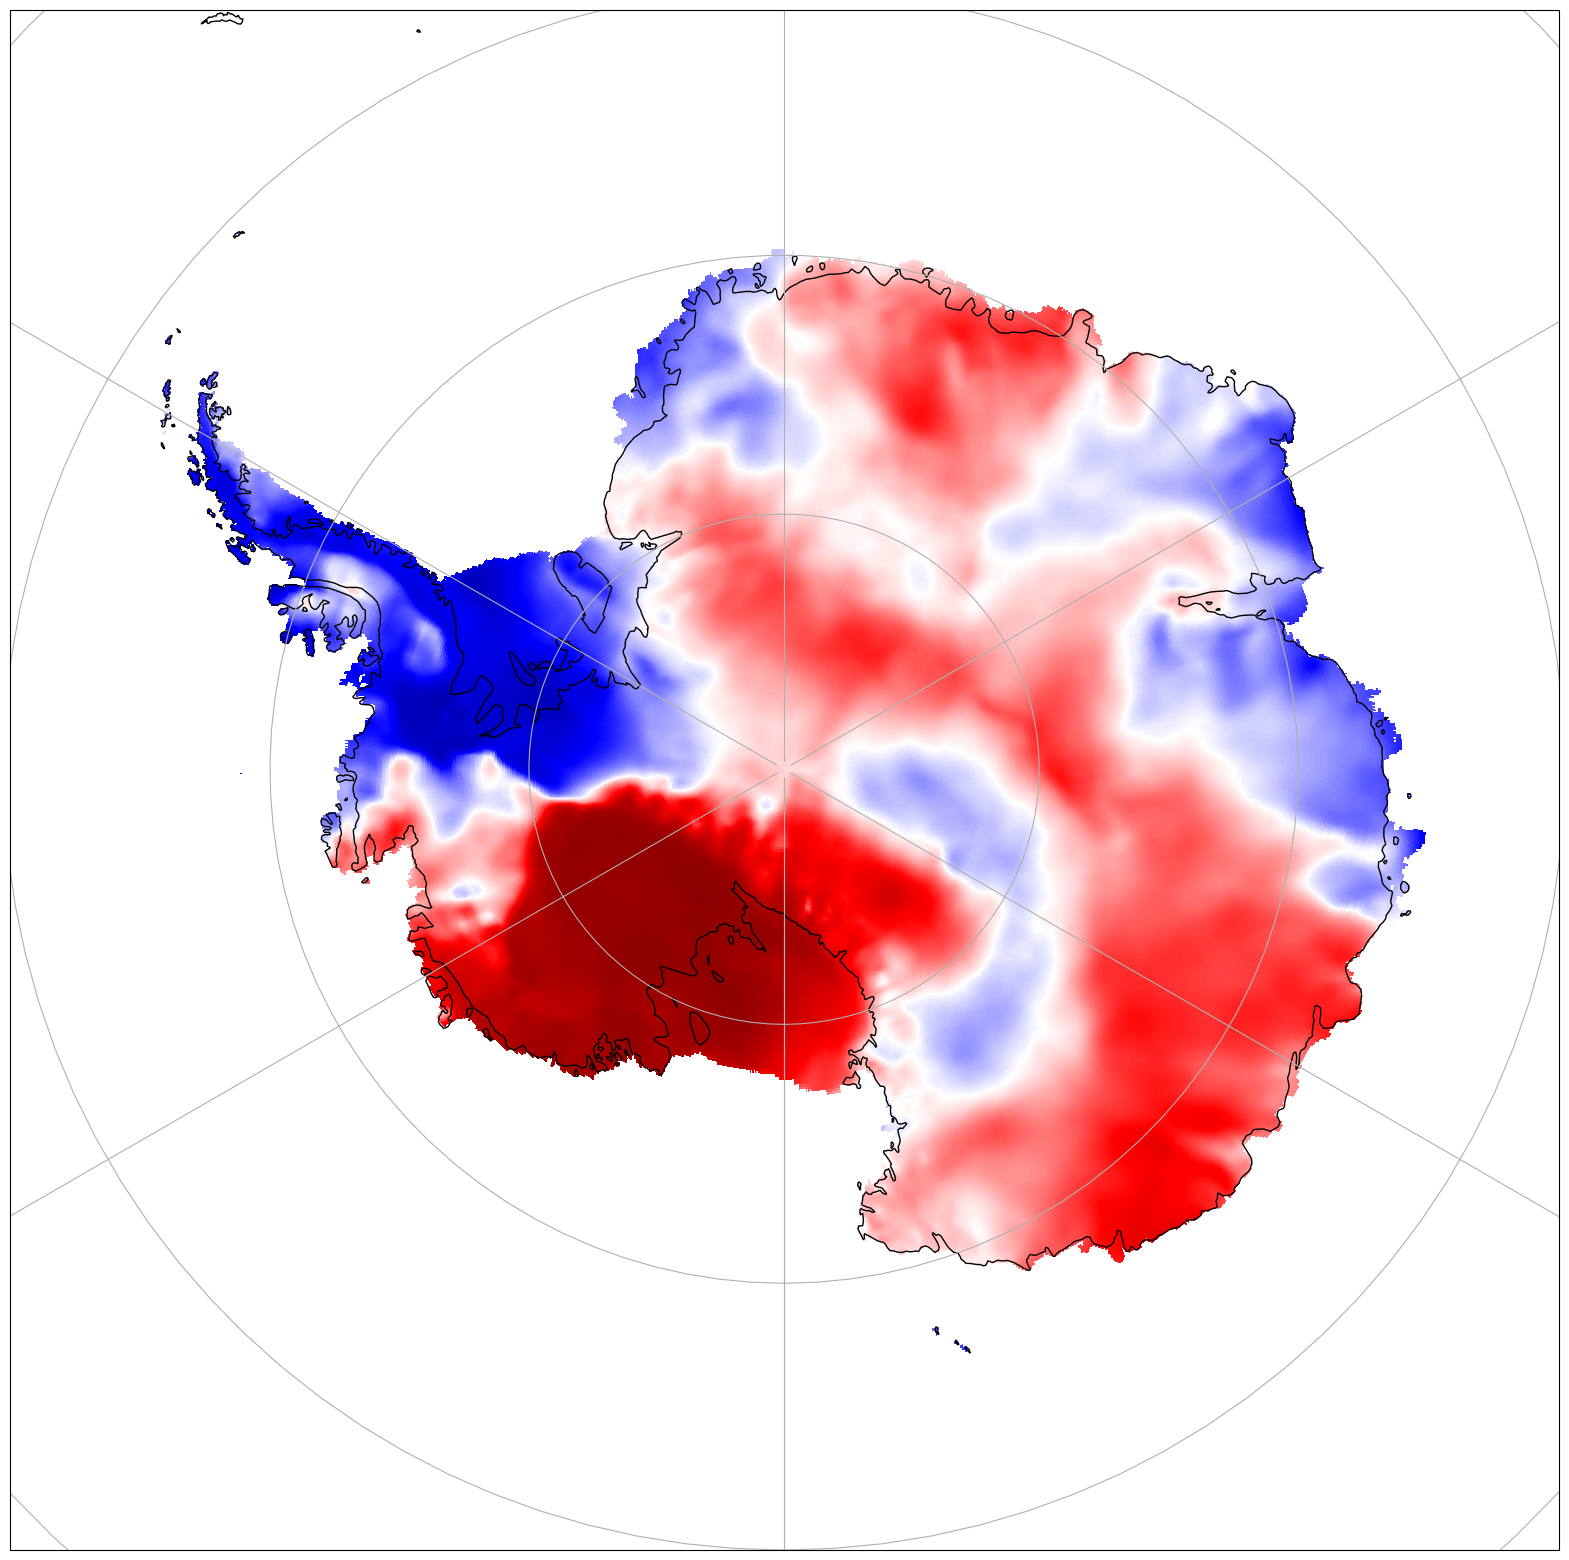

In [31]:
# Plotting the correlations between ice core accumulation records and ERA5 accumulation metric
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax.gridlines()

plt.rcParams['figure.figsize'] = [20, 20]


ax.coastlines()
plt.pcolormesh(lons, lats, corr, vmin=-1, vmax=1, cmap=plt.cm.seismic, transform=ccrs.PlateCarree())

plt.show()


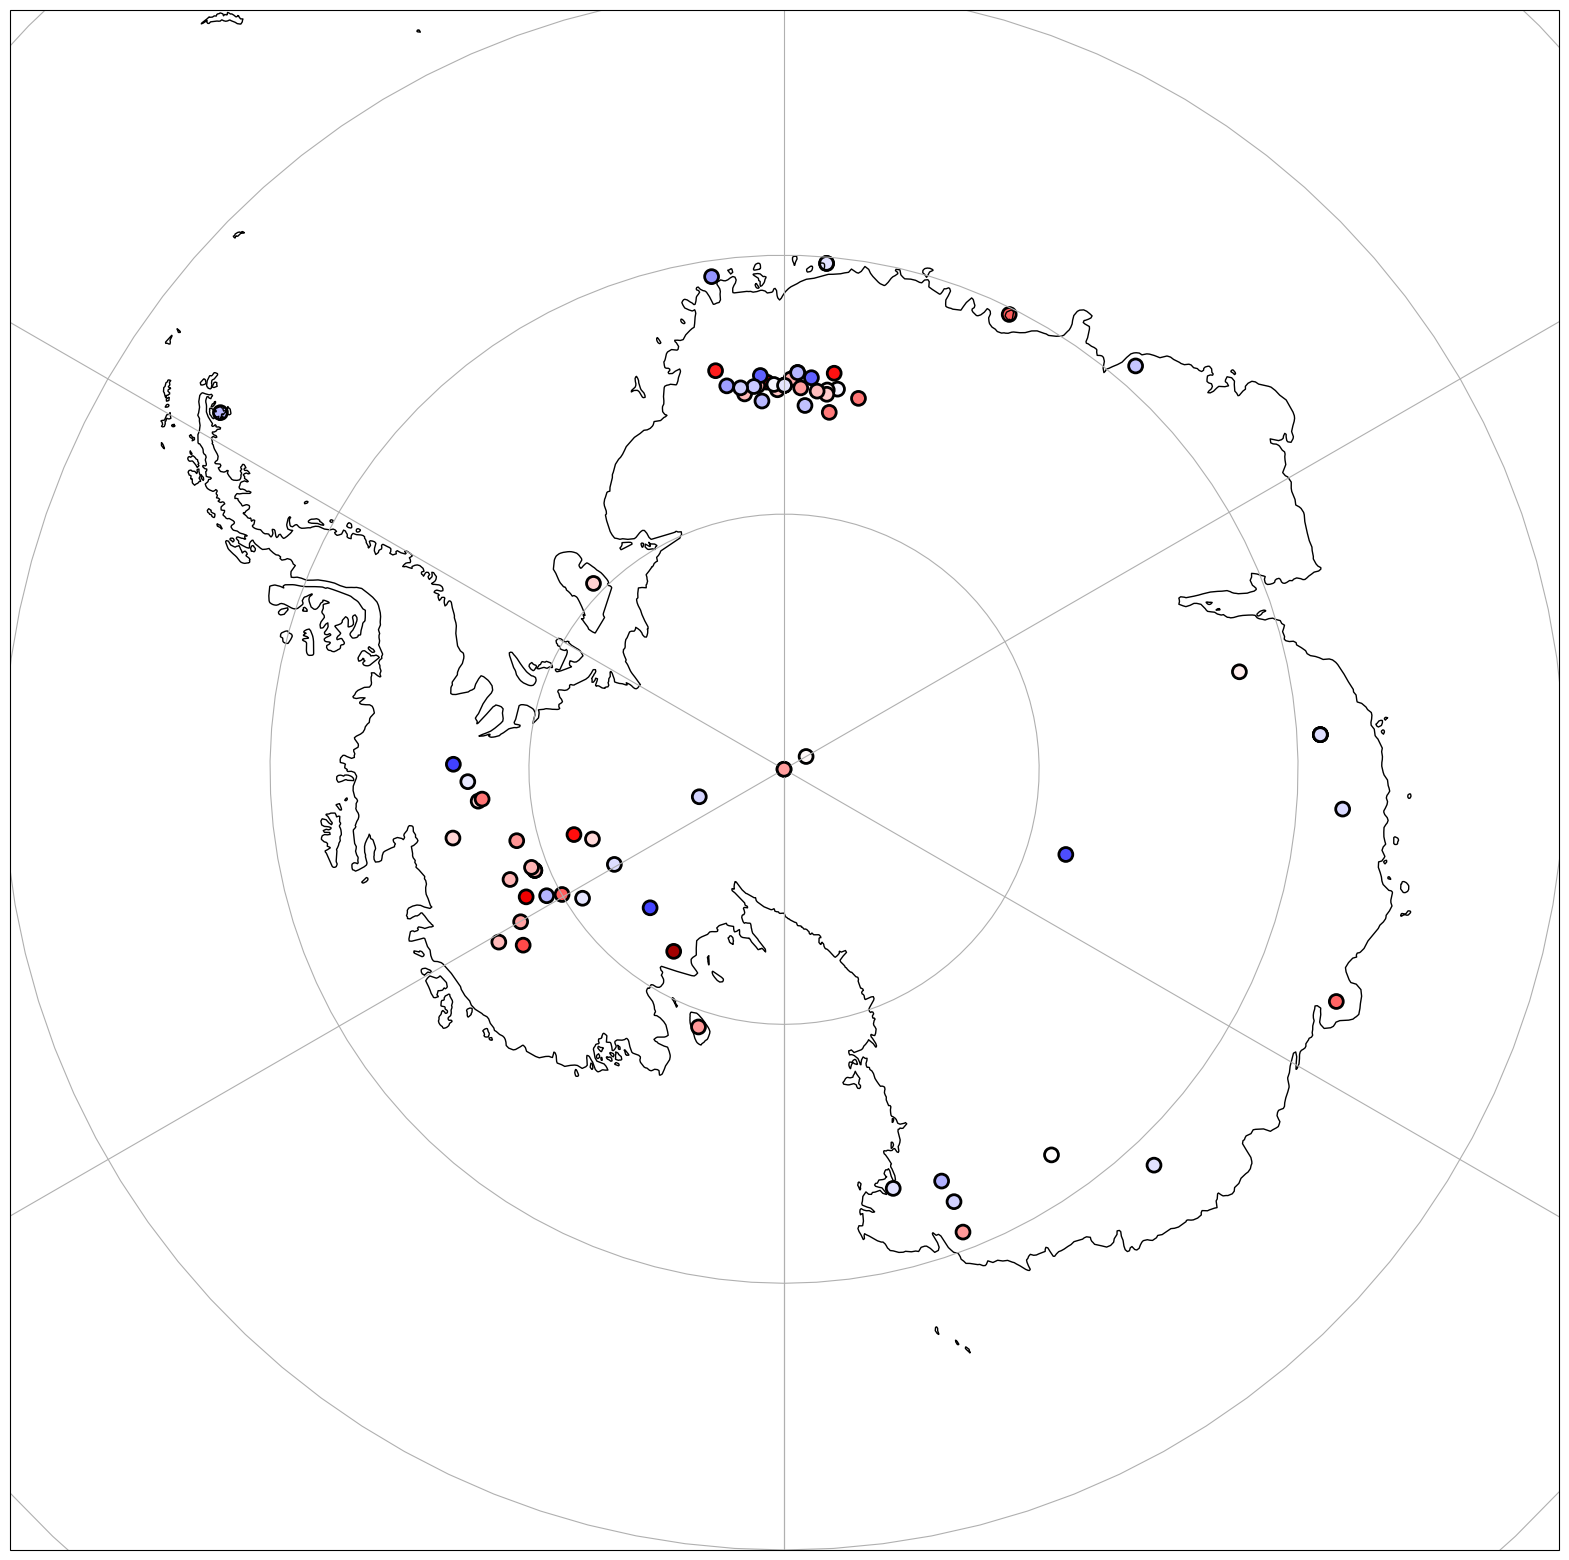

In [17]:
# Plotting the correlations between ice core accumulation records and ERA5 accumulation metric
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax.gridlines()

plt.rcParams['figure.figsize'] = [20, 20]


ax.coastlines()
plt.scatter(accumCoordsInd[:, 1], accumCoordsInd[:, 0], c=correlations_accum_ap, s=100, linewidth=2, edgecolors='black', alpha=1, cmap=plt.cm.seismic, vmin=-1, vmax=1, zorder=1, transform=ccrs.PlateCarree())

plt.show()


In [333]:
# Constructing the linear PSMs, finding R values

alphas_ais = np.zeros(n_cores)       # intercepts α_j
betas_ais = np.zeros(n_cores)        # slopes β_j
error_var_ais = np.zeros(n_cores)   # residual variances R_j
norm_error_var_ais = np.zeros(n_cores)   # normalized residual variances

for i in range(n_cores):
    y = accumCores[:, i]         # Proxy record (22, )
    #X = era5_accum_ais               # Continental metric (22, )
    X = era5_accum_ais               # Continental metric (22, )

    # Mask out missing values in either
    valid_mask = ~np.isnan(y) & ~np.isnan(X)
    yv = y[valid_mask]
    Xv = X[valid_mask].reshape(-1, 1)

    # Only fit if enough valid points exist
    if len(yv) > 2:
        lm = LinearRegression().fit(Xv, yv)
        alphas_ais[i] = lm.intercept_
        betas_ais[i] = lm.coef_[0]
        y_pred = lm.predict(Xv)
        error_var_ais[i] = np.var(yv - y_pred, ddof=1)  # Residual variance (R value)
        total_var = np.var(yv, ddof=1)
        norm_error_var_ais[i] = error_var_ais[i] / total_var 
    else:
        alphas_ais[i] = np.nan
        betas_ais[i] = np.nan
        ReferenceError[i] = np.nan

In [334]:
# Loading the MME prior (size 1001 ensembles)
#accum_AIS_prior = np.array(pd.read_csv(home_path + path + "/MME_AIS_Accum.csv"))[:, 0]
accum_AIS_prior = np.array(pd.read_csv(home_path + path + "/MME_AIS_Accum.csv"))[:, 0]

x_b = np.copy(accum_AIS_prior)

num_years = 200
start_year = 1801
end_year = 2000
n_ens = len(x_b)
n_cores = accumCores.shape[1]

# Extracting the ice core accumulation data for the reconstruction's years 
accumRecord = accumData.iloc[2:, 1:][
    (accumData.iloc[2:, 0].astype(int) >= start_year) & (accumData.iloc[2:, 0].astype(int) <= end_year)
].to_numpy()[::-1]
accumRecord = accumRecord.astype(float)

# Computing the Kalman gain matrix
B = np.var(x_b, ddof=1)
H = betas_ais.reshape(-1, 1)
R = np.diag(norm_error_var_ais)

S = B * (H @ H.T) + R
#S = B * (H @ H.T)
BHt = (B * H.T)

S_inv = np.linalg.pinv(S)
K = BHt @ S_inv




In [335]:
accum_AIS_posterior = np.zeros((n_ens, num_years))

for i in range(num_years):
    currentYear = start_year + i

    x_a = np.zeros(n_ens)  # posterior ensemble

    for j in range(n_ens):
        y = accumRecord[i, :] # proxy observations for year i (84, )
        y_e = np.zeros(n_cores)  # expected proxy observations for year i (84, )

        mask = ~np.isnan(y)

        for k in range(n_cores):
            y_e[k] = alphas_ais[k] + betas_ais[k] * x_b[j] # implementing the PSM 

        y_valid = y[mask]
        y_e_valid = y_e[mask]
        K_valid = K[:, mask]
        
        x_a[j] = x_b[j] + K_valid @ (y_valid - y_e_valid)  # kalman update


    accum_AIS_posterior[:, i] = x_a

/var/folders/4d/5th1wr_s21g614c74mcbh9kc0000gn/T/ipykernel_87104/939047144.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_a[j] = x_b[j] + K_valid @ (y_valid - y_e_valid)  # kalman update


In [336]:
prior_mean_ais = np.mean(x_b)
posterior_mean_ais = np.mean(accum_AIS_posterior, axis=0)

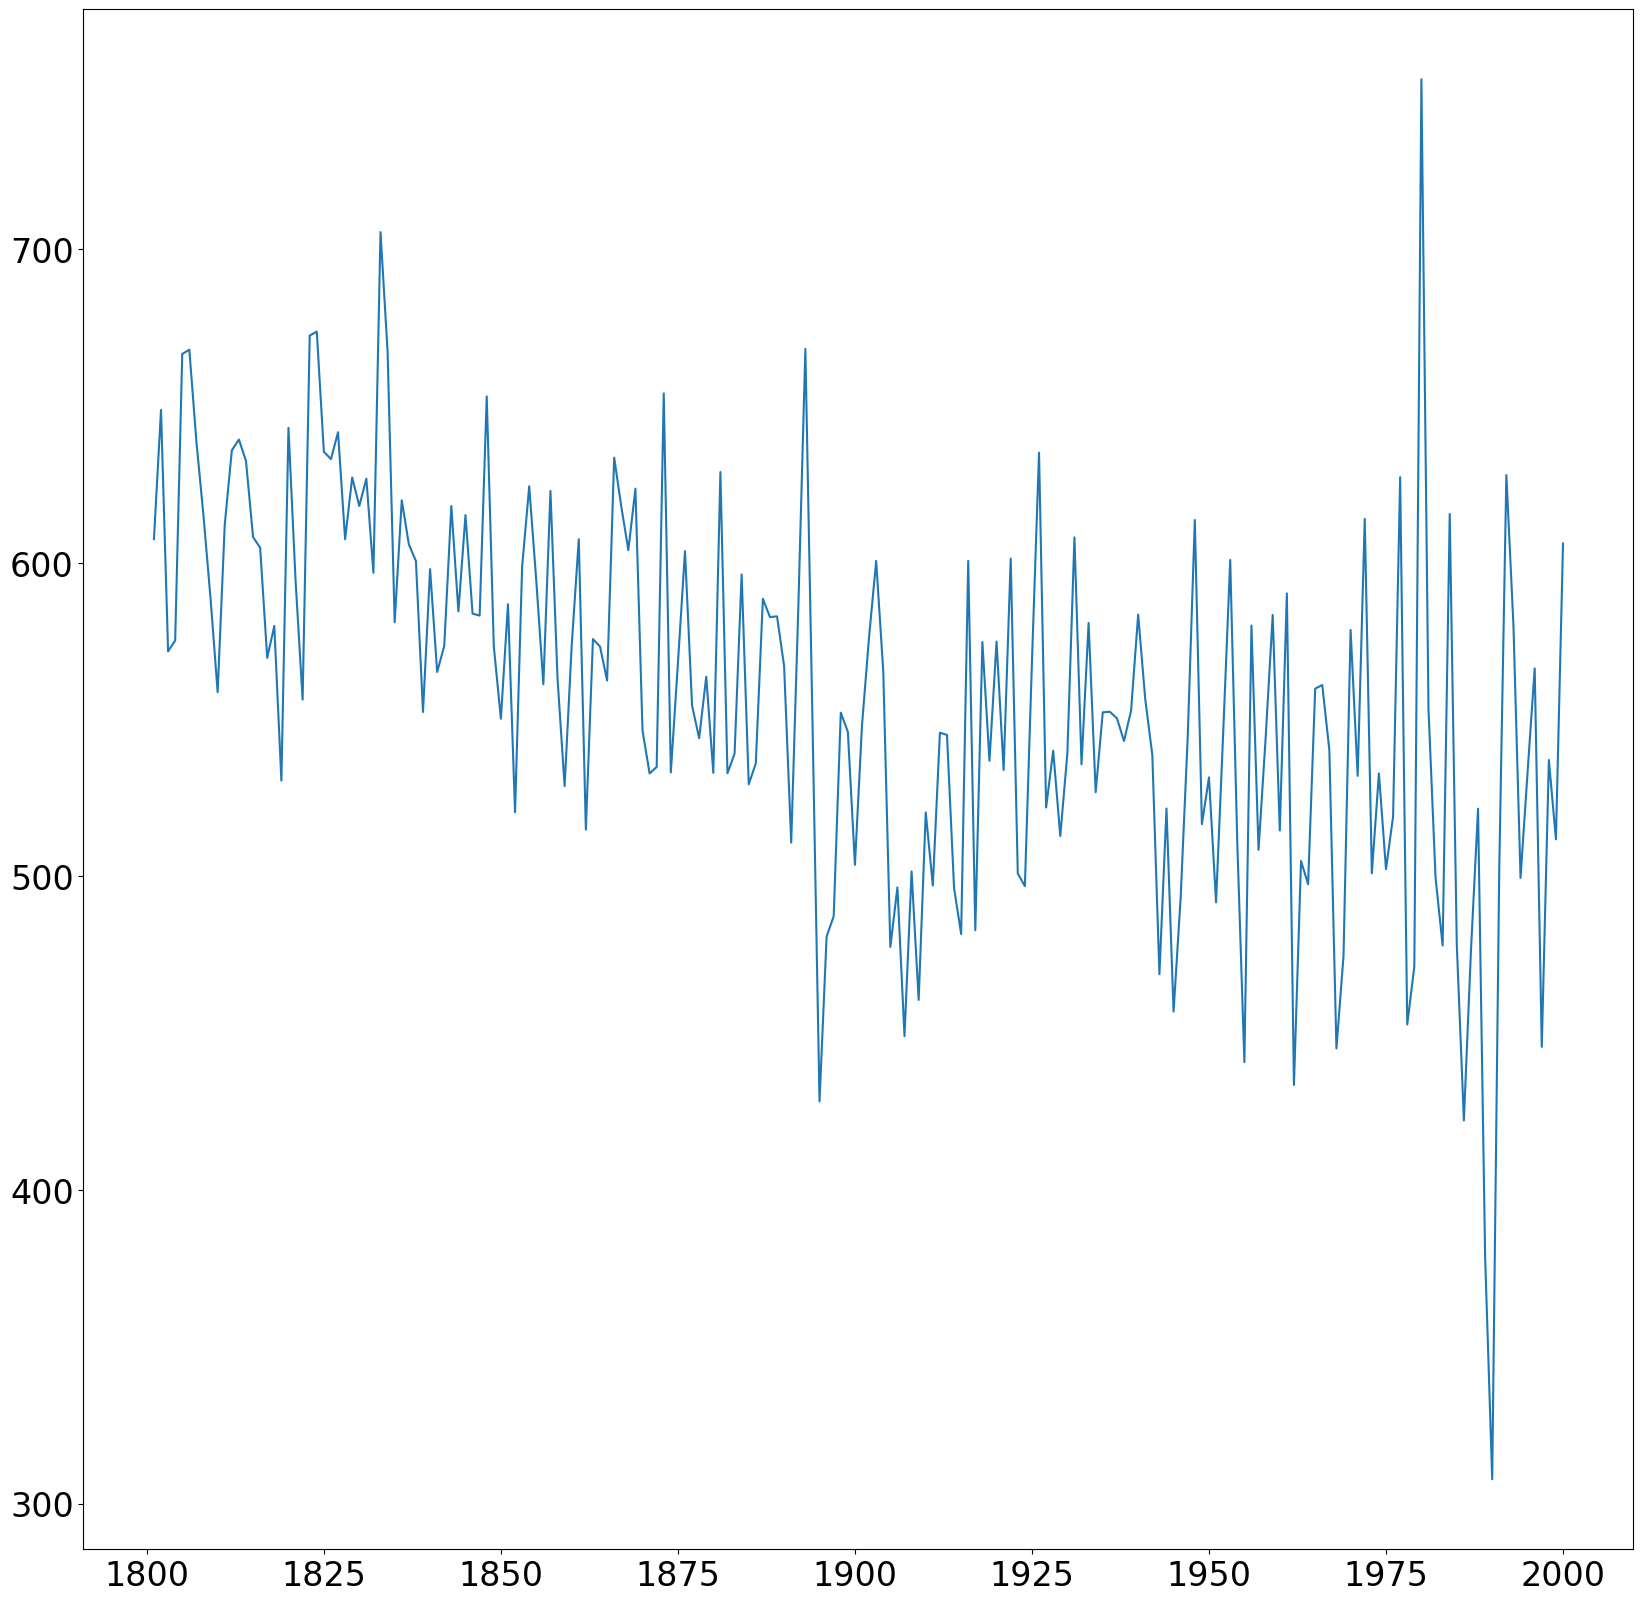

In [337]:
years = np.arange(1801, 2001, 1)

plt.plot(years, posterior_mean_ais)
plt.tick_params(axis='both', which='major', labelsize=24)

In [338]:
# Constructing the linear PSMs, finding R values

alphas_wais = np.zeros(n_cores)       # intercepts α_j
betas_wais = np.zeros(n_cores)        # slopes β_j
error_var_wais = np.zeros(n_cores)   # residual variances R_j
norm_error_var_wais = np.zeros(n_cores)   # normalized residual variances

for i in range(n_cores):
    y = accumCores[:, i]         # Proxy record (22, )
    #X = era5_accum_ais               # Continental metric (22, )
    X = era5_accum_wais               # Continental metric (22, )

    # Mask out missing values in either
    valid_mask = ~np.isnan(y) & ~np.isnan(X)
    yv = y[valid_mask]
    Xv = X[valid_mask].reshape(-1, 1)

    # Only fit if enough valid points exist
    if len(yv) > 2:
        lm = LinearRegression().fit(Xv, yv)
        alphas_wais[i] = lm.intercept_
        betas_wais[i] = lm.coef_[0]
        y_pred = lm.predict(Xv)
        error_var_wais[i] = np.var(yv - y_pred, ddof=1)  # Residual variance (R value)
        total_var = np.var(yv, ddof=1)
        norm_error_var_wais[i] = error_var_wais[i] / total_var 
    else:
        alphas_wais[i] = np.nan
        betas_wais[i] = np.nan
        ReferenceError[i] = np.nan

In [339]:
# Loading the MME prior (size 1001 ensembles)
#accum_AIS_prior = np.array(pd.read_csv(home_path + path + "/MME_AIS_Accum.csv"))[:, 0]
accum_WAIS_prior = np.array(pd.read_csv(home_path + path + "/MME_WAIS_Accum.csv"))[:, 0]

x_b = np.copy(accum_WAIS_prior)

num_years = 200
start_year = 1801
end_year = 2000
n_ens = len(x_b)
n_cores = accumCores.shape[1]

# Extracting the ice core accumulation data for the reconstruction's years 
accumRecord = accumData.iloc[2:, 1:][
    (accumData.iloc[2:, 0].astype(int) >= start_year) & (accumData.iloc[2:, 0].astype(int) <= end_year)
].to_numpy()[::-1]
accumRecord = accumRecord.astype(float)

# Computing the Kalman gain matrix
B = np.var(x_b, ddof=1)
H = betas_wais.reshape(-1, 1)
R = np.diag(norm_error_var_wais)

S = B * (H @ H.T) + R
#S = B * (H @ H.T)
BHt = (B * H.T)

S_inv = np.linalg.pinv(S)
K = BHt @ S_inv




In [340]:
accum_WAIS_posterior = np.zeros((n_ens, num_years))

for i in range(num_years):
    currentYear = start_year + i

    x_a = np.zeros(n_ens)  # posterior ensemble

    for j in range(n_ens):
        y = accumRecord[i, :] # proxy observations for year i (84, )
        y_e = np.zeros(n_cores)  # expected proxy observations for year i (84, )

        mask = ~np.isnan(y)

        for k in range(n_cores):
            y_e[k] = alphas_wais[k] + betas_wais[k] * x_b[j] # implementing the PSM 

        y_valid = y[mask]
        y_e_valid = y_e[mask]
        K_valid = K[:, mask]
        
        x_a[j] = x_b[j] + K_valid @ (y_valid - y_e_valid)  # kalman update


    accum_WAIS_posterior[:, i] = x_a

/var/folders/4d/5th1wr_s21g614c74mcbh9kc0000gn/T/ipykernel_87104/3460058497.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_a[j] = x_b[j] + K_valid @ (y_valid - y_e_valid)  # kalman update


In [341]:
prior_mean_wais = np.mean(x_b)
posterior_mean_wais = np.mean(accum_WAIS_posterior, axis=0)

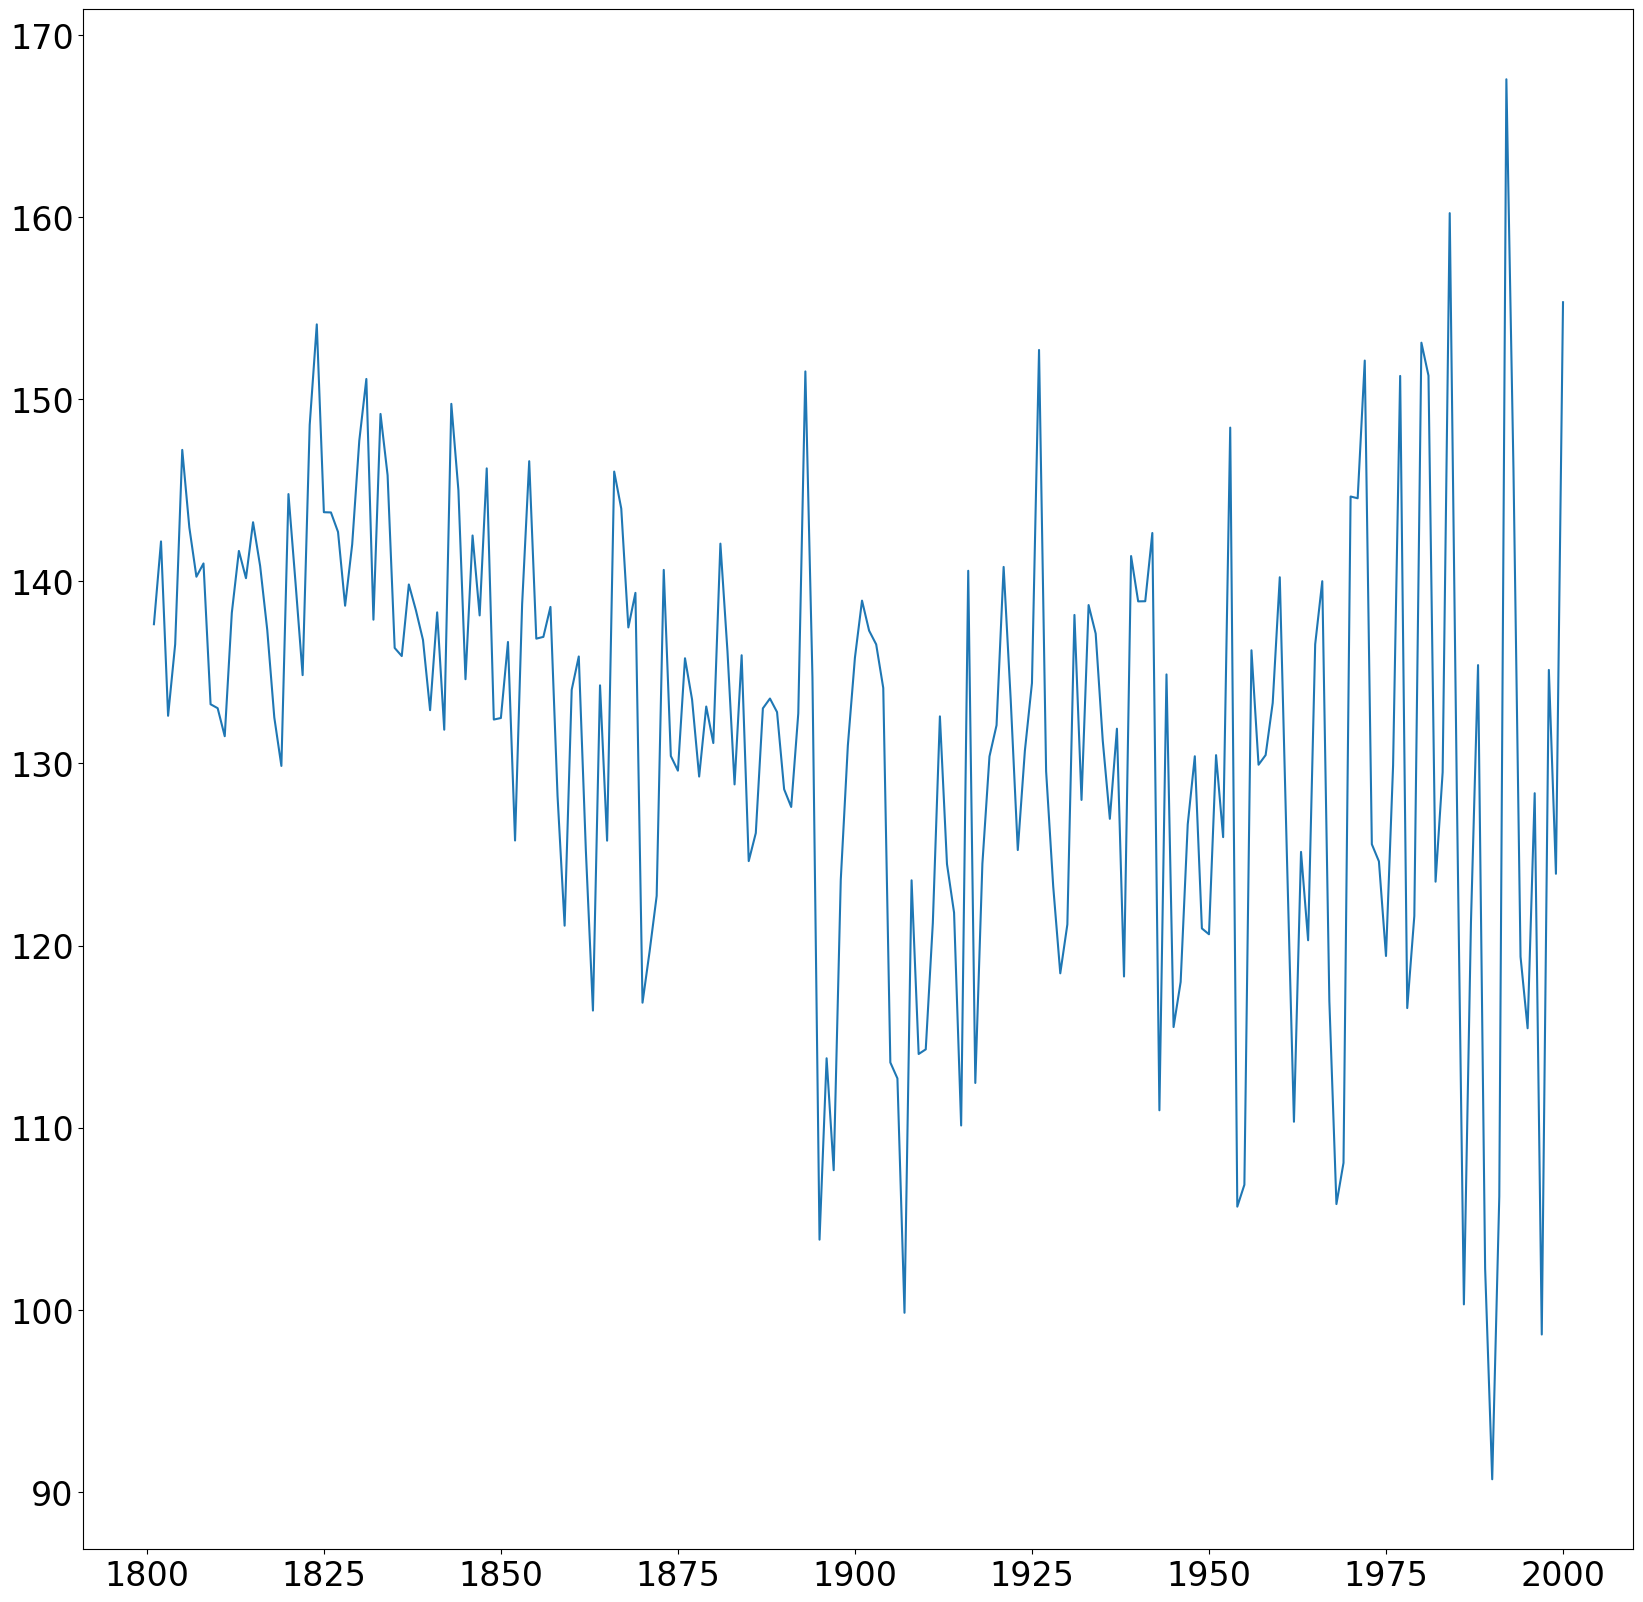

In [342]:
plt.plot(years, posterior_mean_wais)
plt.tick_params(axis='both', which='major', labelsize=24)

In [351]:
# Constructing the linear PSMs, finding R values

alphas_eais = np.zeros(n_cores)       # intercepts α_j
betas_eais = np.zeros(n_cores)        # slopes β_j
error_var_eais = np.zeros(n_cores)   # residual variances R_j
norm_error_var_eais = np.zeros(n_cores)   # normalized residual variances

for i in range(n_cores):
    y = accumCores[:, i]         # Proxy record (22, )
    #X = era5_accum_ais               # Continental metric (22, )
    X = era5_accum_eais               # Continental metric (22, )

    # Mask out missing values in either
    valid_mask = ~np.isnan(y) & ~np.isnan(X)
    yv = y[valid_mask]
    Xv = X[valid_mask].reshape(-1, 1)

    # Only fit if enough valid points exist
    if len(yv) > 2:
        lm = LinearRegression().fit(Xv, yv)
        alphas_eais[i] = lm.intercept_
        betas_eais[i] = lm.coef_[0]
        y_pred = lm.predict(Xv)
        error_var_eais[i] = np.var(yv - y_pred, ddof=1)  # Residual variance (R value)
        total_var = np.var(yv, ddof=1)
        norm_error_var_eais[i] = error_var_eais[i] / total_var 
    else:
        alphas_eais[i] = np.nan
        betas_eais[i] = np.nan
        ReferenceError[i] = np.nan

In [ ]:
# Loading the MME prior (size 1001 ensembles)
#accum_AIS_prior = np.array(pd.read_csv(home_path + path + "/MME_AIS_Accum.csv"))[:, 0]
accum_EAIS_prior = np.array(pd.read_csv(home_path + path + "/MME_EAIS_Accum.csv"))[:, 0]

x_b = np.copy(accum_EAIS_prior)

num_years = 200
start_year = 1801
end_year = 2000
n_ens = len(x_b)
n_cores = accumCores.shape[1]

# Extracting the ice core accumulation data for the reconstruction's years 
accumRecord = accumData.iloc[2:, 1:][
    (accumData.iloc[2:, 0].astype(int) >= start_year) & (accumData.iloc[2:, 0].astype(int) <= end_year)
].to_numpy()[::-1]
accumRecord = accumRecord.astype(float)

# Computing the Kalman gain matrix
B = np.var(x_b, ddof=1)
H = betas_eais.reshape(-1, 1)
R = np.diag(norm_error_var_eais)

S = B * (H @ H.T) + R
#S = B * (H @ H.T)
BHt = (B * H.T)

S_inv = np.linalg.pinv(S)
K = BHt @ S_inv




In [353]:
accum_EAIS_posterior = np.zeros((n_ens, num_years))

for i in range(num_years):
    currentYear = start_year + i

    x_a = np.zeros(n_ens)  # posterior ensemble

    for j in range(n_ens):
        y = accumRecord[i, :] # proxy observations for year i (84, )
        y_e = np.zeros(n_cores)  # expected proxy observations for year i (84, )

        mask = ~np.isnan(y)

        for k in range(n_cores):
            y_e[k] = alphas_eais[k] + betas_eais[k] * x_b[j] # implementing the PSM 

        y_valid = y[mask]
        y_e_valid = y_e[mask]
        K_valid = K[:, mask]
        
        x_a[j] = x_b[j] + K_valid @ (y_valid - y_e_valid)  # kalman update


    accum_EAIS_posterior[:, i] = x_a

/var/folders/4d/5th1wr_s21g614c74mcbh9kc0000gn/T/ipykernel_87104/958351441.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_a[j] = x_b[j] + K_valid @ (y_valid - y_e_valid)  # kalman update


In [354]:
prior_mean_eais = np.mean(x_b)
posterior_mean_eais = np.mean(accum_EAIS_posterior, axis=0)

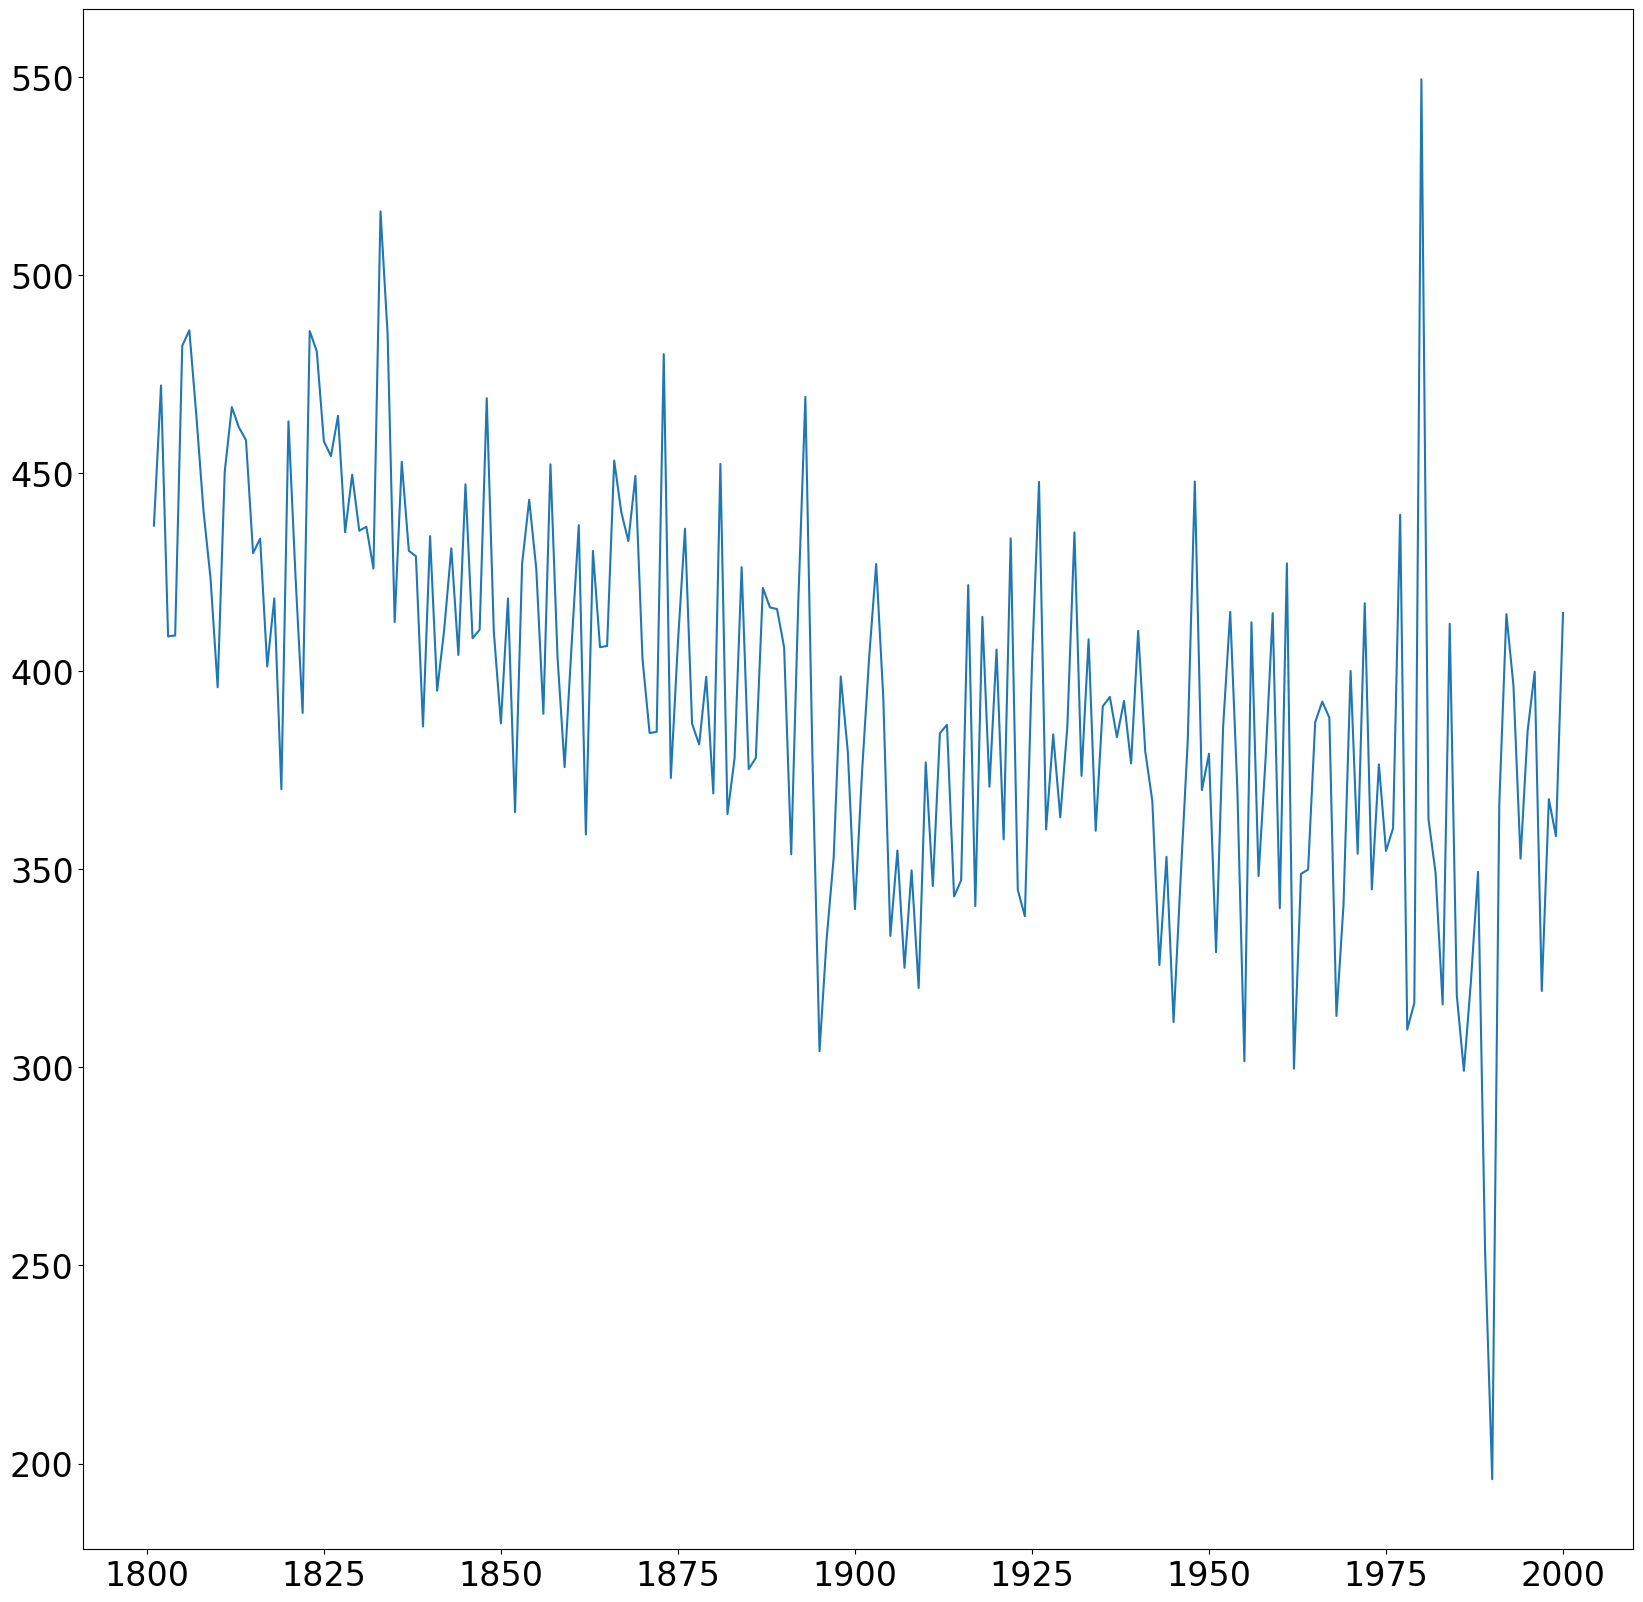

In [355]:
plt.plot(years, posterior_mean_eais)
plt.tick_params(axis='both', which='major', labelsize=24)

In [382]:
# Constructing the linear PSMs, finding R values

alphas_ap = np.zeros(n_cores)       # intercepts α_j
betas_ap = np.zeros(n_cores)        # slopes β_j
error_var_ap = np.zeros(n_cores)   # residual variances R_j
norm_error_var_ap = np.zeros(n_cores)   # normalized residual variances

for i in range(n_cores):
    y = accumCores[:, i]         # Proxy record (22, )
    #X = era5_accum_ais               # Continental metric (22, )
    X = era5_accum_ap               # Continental metric (22, )

    # Mask out missing values in either
    valid_mask = ~np.isnan(y) & ~np.isnan(X)
    yv = y[valid_mask]
    Xv = X[valid_mask].reshape(-1, 1)

    # Only fit if enough valid points exist
    if len(yv) > 2:
        lm = LinearRegression().fit(Xv, yv)
        alphas_ap[i] = lm.intercept_
        betas_ap[i] = lm.coef_[0]
        y_pred = lm.predict(Xv)
        error_var_ap[i] = np.var(yv - y_pred, ddof=1)  # Residual variance (R value)
        total_var = np.var(yv, ddof=1)
        norm_error_var_ap[i] = error_var_ap[i] / total_var 
    else:
        alphas_ap[i] = np.nan
        betas_ap[i] = np.nan
        ReferenceError[i] = np.nan

In [383]:
# Loading the MME prior (size 1001 ensembles)
#accum_AIS_prior = np.array(pd.read_csv(home_path + path + "/MME_AIS_Accum.csv"))[:, 0]
accum_AP_prior = np.array(pd.read_csv(home_path + path + "/MME_AP_Accum.csv"))[:, 0]

x_b = np.copy(accum_AP_prior)

num_years = 200
start_year = 1801
end_year = 2000
n_ens = len(x_b)
n_cores = accumCores.shape[1]

# Extracting the ice core accumulation data for the reconstruction's years 
accumRecord = accumData.iloc[2:, 1:][
    (accumData.iloc[2:, 0].astype(int) >= start_year) & (accumData.iloc[2:, 0].astype(int) <= end_year)
].to_numpy()[::-1]
accumRecord = accumRecord.astype(float)

# Computing the Kalman gain matrix
B = np.var(x_b, ddof=1)
H = betas_ap.reshape(-1, 1)
R = np.diag(norm_error_var_ap)

S = B * (H @ H.T) + R
#S = B * (H @ H.T)
BHt = (B * H.T)

S_inv = np.linalg.pinv(S)
K = BHt @ S_inv




In [384]:
accum_AP_posterior = np.zeros((n_ens, num_years))

for i in range(num_years):
    currentYear = start_year + i

    x_a = np.zeros(n_ens)  # posterior ensemble

    for j in range(n_ens):
        y = accumRecord[i, :] # proxy observations for year i (84, )
        y_e = np.zeros(n_cores)  # expected proxy observations for year i (84, )

        mask = ~np.isnan(y)

        for k in range(n_cores):
            y_e[k] = alphas_ap[k] + betas_ap[k] * x_b[j] # implementing the PSM 

        y_valid = y[mask]
        y_e_valid = y_e[mask]
        K_valid = K[:, mask]
        
        x_a[j] = x_b[j] + K_valid @ (y_valid - y_e_valid)  # kalman update


    accum_AP_posterior[:, i] = x_a

/var/folders/4d/5th1wr_s21g614c74mcbh9kc0000gn/T/ipykernel_87104/2156373182.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_a[j] = x_b[j] + K_valid @ (y_valid - y_e_valid)  # kalman update


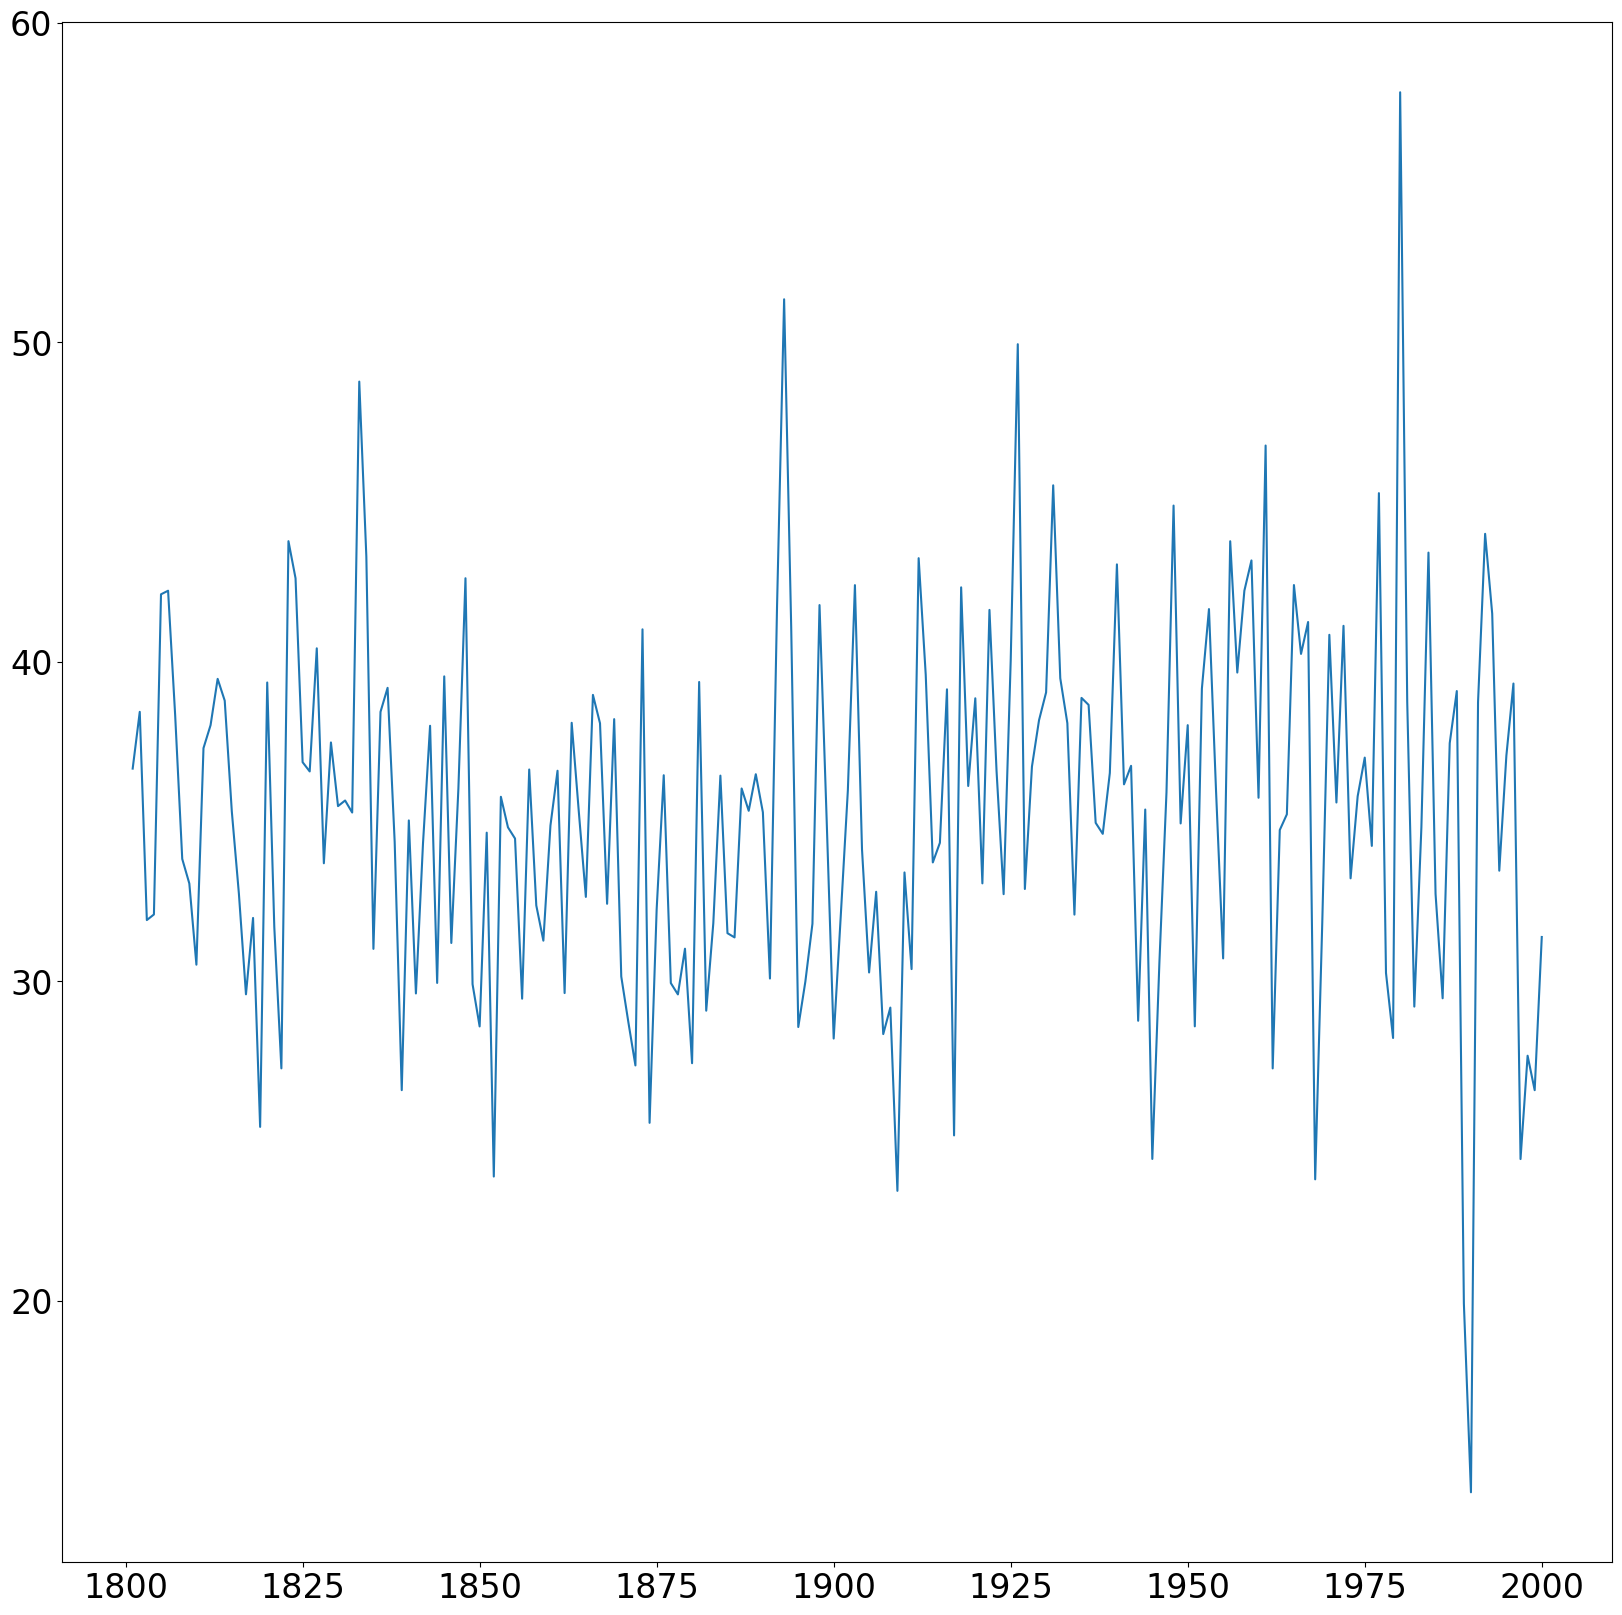

In [385]:
prior_mean_ap = np.mean(x_b)
posterior_mean_ap = np.mean(accum_AP_posterior, axis=0)

plt.plot(years, posterior_mean_ap)
plt.tick_params(axis='both', which='major', labelsize=24)

In [390]:
for i in range(200):
    print(posterior_mean_eais[i])

436.7759035491598
472.1556618948437
408.8064796835511
409.05787247037006
482.1682006480022
486.0867990412622
464.3553360733023
440.4969723949374
423.3289837589776
395.9754996030905
450.40748305287326
466.69364224294264
461.590527990324
458.37988199483425
429.8379483986459
433.48793763785574
401.2122713924656
418.40021103323204
370.22098136797507
463.0990591084609
423.787018060255
389.4891576665273
485.9034646662265
480.77974502012574
458.0870658938484
454.3275908718964
464.51688716089063
435.11190493088924
449.6442704095387
435.4892503861381
436.488858685115
425.9337241515164
516.1063771321243
485.16746980097156
412.42537352418594
452.88344225912857
430.4295721315497
429.04415053079686
386.0628072482447
434.1216610173545
395.0910918240549
410.6435460753396
431.0352256793871
404.11799648225923
447.2224969977453
408.33881172223954
410.49713090483937
468.9434065824661
410.02229132713904
386.8499982163937
418.3963923787136
364.4596305482439
427.2386489902432
443.3022600649672
425.842887577